In [2]:
spark = SparkSession.builder.appName("NYPD").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

24/12/17 11:46:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Import Libraries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import display, HTML

import math
import time


from pyspark import SparkContext
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.functions import sqrt, pow, mean

import folium
from folium.plugins import HeatMap


from pyspark.ml.regression import LinearRegression

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import ClusteringEvaluator


from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



In [4]:
#https://storage.cloud.google.com/nypdbucket/notebooks/jupyter/nypd_dataset.csv
csv_file_path = "gs://nypdbucket1/notebooks/jupyter/nypd_dataset.csv"

df = (spark.read.format("csv")
     .option("header", "true")  
     .option("inferSchema", "true") 
     .load(csv_file_path))

df.show(5)



+-----------+-----------+-------------+-------------------+-----------+--------+--------------------+--------+--------+----------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+---------+----------+
|CAD_EVNT_ID|CREATE_DATE|INCIDENT_DATE|      INCIDENT_TIME|NYPD_PCT_CD| BORO_NM|       PATRL_BORO_NM|GEO_CD_X|GEO_CD_Y|RADIO_CODE|            TYP_DESC|CIP_JOBS|              ADD_TS|             DISP_TS|           ARRIVD_TS|           CLOSNG_TS| Latitude| Longitude|
+-----------+-----------+-------------+-------------------+-----------+--------+--------------------+--------+--------+----------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+---------+----------+
|   99842231| 01/01/2024|   12/31/2023|2024-12-17 22:11:38|         45|   BRONX|   PATROL BORO BRONX| 1031438|  249344|      52D6|     DISPUTE: FAMILY| Non CIP|01/01/2024 12:02:...|01/01/2024 12:02:...|

In [5]:
df.printSchema()

root
 |-- CAD_EVNT_ID: integer (nullable = true)
 |-- CREATE_DATE: string (nullable = true)
 |-- INCIDENT_DATE: string (nullable = true)
 |-- INCIDENT_TIME: timestamp (nullable = true)
 |-- NYPD_PCT_CD: integer (nullable = true)
 |-- BORO_NM: string (nullable = true)
 |-- PATRL_BORO_NM: string (nullable = true)
 |-- GEO_CD_X: integer (nullable = true)
 |-- GEO_CD_Y: integer (nullable = true)
 |-- RADIO_CODE: string (nullable = true)
 |-- TYP_DESC: string (nullable = true)
 |-- CIP_JOBS: string (nullable = true)
 |-- ADD_TS: string (nullable = true)
 |-- DISP_TS: string (nullable = true)
 |-- ARRIVD_TS: string (nullable = true)
 |-- CLOSNG_TS: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [6]:
df.describe().show()

24/12/17 11:46:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+-----------+-------------+-----------------+-------------+--------------------+------------------+-----------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+
|summary|        CAD_EVNT_ID|CREATE_DATE|INCIDENT_DATE|      NYPD_PCT_CD|      BORO_NM|       PATRL_BORO_NM|          GEO_CD_X|         GEO_CD_Y|         RADIO_CODE|            TYP_DESC|CIP_JOBS|              ADD_TS|             DISP_TS|           ARRIVD_TS|           CLOSNG_TS|           Latitude|         Longitude|
+-------+-------------------+-----------+-------------+-----------------+-------------+--------------------+------------------+-----------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+
|  count|            5430525|    5430525|  

# Data Cleaning

In [7]:
print("Duplicate Rows:", df.count() - df.distinct().count())

Duplicate Rows: 0



[Stage 11:===================================================>    (12 + 1) / 13]



In [8]:
arr_null_count = df.filter(F.col("ARRIVD_TS").isNull()).count()
clo_null_count = df.filter(F.col("CLOSNG_TS").isNull()).count()
pct_null_count = df.filter(F.col("NYPD_PCT_CD").isNull()).count()

print(f"Number of rows with NULL values in ARRIVD_TS: {arr_null_count}")
print(f"Number of rows with NULL values in CLOSNG_TS: {clo_null_count}")
print(f"Number of rows with NULL values in NYPD_PCT_CD: {pct_null_count}")

Number of rows with NULL values in ARRIVD_TS: 1138027
Number of rows with NULL values in CLOSNG_TS: 33
Number of rows with NULL values in NYPD_PCT_CD: 1


In [9]:
# Drop rows where ARRIVD_TS or CLOSNG_TS is NULL
df_cleaned = df.filter((F.col("ARRIVD_TS").isNotNull()) & (F.col("CLOSNG_TS").isNotNull()))

# Show counts after dropping rows
print("Total rows after dropping NULL values in ARRIVD_TS and CLOSNG_TS:", df_cleaned.count())

# Verify NULLs again
df_cleaned.select(
    F.col("ARRIVD_TS").isNull().alias("ARRIVD_TS_NULL"),
    F.col("CLOSNG_TS").isNull().alias("CLOSNG_TS_NULL")
).show(1)


Total rows after dropping NULL values in ARRIVD_TS and CLOSNG_TS: 4292472
+--------------+--------------+
|ARRIVD_TS_NULL|CLOSNG_TS_NULL|
+--------------+--------------+
|         false|         false|
|         false|         false|
|         false|         false|
|         false|         false|
|         false|         false|
+--------------+--------------+
only showing top 5 rows



In [10]:
# Fill NULL value in NYPD_PCT_CD with 'UNKNOWN'
df_cleaned = df_cleaned.fillna({"NYPD_PCT_CD": "UNKNOWN"})

# Verify NULLs in NYPD_PCT_CD
print("NULL values in NYPD_PCT_CD after filling:")
df_cleaned.filter(F.col("NYPD_PCT_CD").isNull()).show()


NULL values in NYPD_PCT_CD after filling:


+-----------+-----------+-------------+-------------+-----------+-------+-------------+--------+--------+----------+--------+--------+------+-------+---------+---------+--------+---------+
|CAD_EVNT_ID|CREATE_DATE|INCIDENT_DATE|INCIDENT_TIME|NYPD_PCT_CD|BORO_NM|PATRL_BORO_NM|GEO_CD_X|GEO_CD_Y|RADIO_CODE|TYP_DESC|CIP_JOBS|ADD_TS|DISP_TS|ARRIVD_TS|CLOSNG_TS|Latitude|Longitude|
+-----------+-----------+-------------+-------------+-----------+-------+-------------+--------+--------+----------+--------+--------+------+-------+---------+---------+--------+---------+
+-----------+-----------+-------------+-------------+-----------+-------+-------------+--------+--------+----------+--------+--------+------+-------+---------+---------+--------+---------+



In [11]:
# Verify NULL counts for all relevant columns
df_cleaned.select(
    F.count(F.when(F.col("ARRIVD_TS").isNull(), 1)).alias("ARRIVD_TS_NULL_COUNT"),
    F.count(F.when(F.col("CLOSNG_TS").isNull(), 1)).alias("CLOSNG_TS_NULL_COUNT"),
    F.count(F.when(F.col("NYPD_PCT_CD").isNull(), 1)).alias("NYPD_PCT_CD_NULL_COUNT")
).show()


+--------------------+--------------------+----------------------+
|ARRIVD_TS_NULL_COUNT|CLOSNG_TS_NULL_COUNT|NYPD_PCT_CD_NULL_COUNT|
+--------------------+--------------------+----------------------+
|                   0|                   0|                     0|
+--------------------+--------------------+----------------------+




[Stage 31:==============================================>         (10 + 2) / 12]



In [12]:
df_cleaned = df_cleaned.drop("CAD_EVNT_ID", "PATRL_BORO_NM","CREATE_DATE")

print("Columns after dropping colums:")
df_cleaned.printSchema()


Columns after dropping colums:
root
 |-- INCIDENT_DATE: string (nullable = true)
 |-- INCIDENT_TIME: timestamp (nullable = true)
 |-- NYPD_PCT_CD: integer (nullable = true)
 |-- BORO_NM: string (nullable = true)
 |-- GEO_CD_X: integer (nullable = true)
 |-- GEO_CD_Y: integer (nullable = true)
 |-- RADIO_CODE: string (nullable = true)
 |-- TYP_DESC: string (nullable = true)
 |-- CIP_JOBS: string (nullable = true)
 |-- ADD_TS: string (nullable = true)
 |-- DISP_TS: string (nullable = true)
 |-- ARRIVD_TS: string (nullable = true)
 |-- CLOSNG_TS: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [13]:
df_cleaned = df_cleaned.withColumn("ADD_TS", F.to_timestamp("ADD_TS", "MM/dd/yyyy hh:mm:ss a")) \
                       .withColumn("DISP_TS", F.to_timestamp("DISP_TS", "MM/dd/yyyy hh:mm:ss a")) \
                       .withColumn("ARRIVD_TS", F.to_timestamp("ARRIVD_TS", "MM/dd/yyyy hh:mm:ss a")) \
                        .withColumn("CLOSNG_TS", F.to_timestamp("CLOSNG_TS", "MM/dd/yyyy hh:mm:ss a"))

print("Schema after converting to timestamp:")
df_cleaned.printSchema()

df_cleaned.select("ADD_TS", "DISP_TS", "ARRIVD_TS", "CLOSNG_TS").show(5, truncate=False)


Schema after converting to timestamp:
root
 |-- INCIDENT_DATE: string (nullable = true)
 |-- INCIDENT_TIME: timestamp (nullable = true)
 |-- NYPD_PCT_CD: integer (nullable = true)
 |-- BORO_NM: string (nullable = true)
 |-- GEO_CD_X: integer (nullable = true)
 |-- GEO_CD_Y: integer (nullable = true)
 |-- RADIO_CODE: string (nullable = true)
 |-- TYP_DESC: string (nullable = true)
 |-- CIP_JOBS: string (nullable = true)
 |-- ADD_TS: timestamp (nullable = true)
 |-- DISP_TS: timestamp (nullable = true)
 |-- ARRIVD_TS: timestamp (nullable = true)
 |-- CLOSNG_TS: timestamp (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)

+-------------------+-------------------+-------------------+-------------------+
|ADD_TS             |DISP_TS            |ARRIVD_TS          |CLOSNG_TS          |
+-------------------+-------------------+-------------------+-------------------+
|2024-01-01 00:01:21|2024-01-01 00:02:19|2024-01-01 01:19:58|2024-01-01 01:20:

In [14]:
df_cleaned = df_cleaned.withColumn("dispatch_time", F.round((F.unix_timestamp("DISP_TS") - F.unix_timestamp("ADD_TS")) / 60, 2)) \
                       .withColumn("arrival_time", F.round((F.unix_timestamp("ARRIVD_TS") - F.unix_timestamp("DISP_TS")) / 60, 2)) \
                       .withColumn("total_response_time", F.round((F.unix_timestamp("ARRIVD_TS") - F.unix_timestamp("ADD_TS")) / 60, 2))

df_cleaned.select("ADD_TS", "DISP_TS", "ARRIVD_TS", "dispatch_time", "arrival_time", "total_response_time").show(10)


+-------------------+-------------------+-------------------+-------------+------------+-------------------+
|             ADD_TS|            DISP_TS|          ARRIVD_TS|dispatch_time|arrival_time|total_response_time|
+-------------------+-------------------+-------------------+-------------+------------+-------------------+
|2024-01-01 00:01:21|2024-01-01 00:02:19|2024-01-01 01:19:58|         0.97|       77.65|              78.62|
|2024-01-01 00:06:11|2024-01-01 00:07:19|2024-01-01 00:19:27|         1.13|       12.13|              13.27|
|2024-01-01 00:04:51|2024-01-01 00:09:21|2024-01-01 00:15:11|          4.5|        5.83|              10.33|
|2024-01-01 00:04:57|2024-01-01 00:12:08|2024-01-01 00:29:16|         7.18|       17.13|              24.32|
|2024-01-01 00:00:07|2024-01-01 00:00:07|2024-01-01 00:00:07|          0.0|         0.0|                0.0|
|2024-01-01 00:00:14|2024-01-01 00:08:24|2024-01-01 00:36:32|         8.17|       28.13|               36.3|
|2024-01-01 00:00:2

In [15]:
dispatch_quantile = df_cleaned.approxQuantile("dispatch_time", [0.95], 0.0)[0]
arrival_quantile = df_cleaned.approxQuantile("arrival_time", [0.95], 0.0)[0]

print(f"95th percentile of dispatch_time: {dispatch_quantile}")
print(f"95th percentile of arrival_time: {arrival_quantile}")

df_cleaned = df_cleaned.filter(
    (F.col("dispatch_time") > 0) & (F.col("dispatch_time") <= dispatch_quantile) &
    (F.col("arrival_time") > 0) & (F.col("arrival_time") <= arrival_quantile)
)

df_cleaned.describe("dispatch_time", "arrival_time").show()


95th percentile of dispatch_time: 20.22
95th percentile of arrival_time: 101.27


+-------+------------------+------------------+
|summary|     dispatch_time|      arrival_time|
+-------+------------------+------------------+
|  count|           1519219|           1519219|
|   mean|3.2156964664086685| 16.94440944327612|
| stddev| 4.220197489145211|22.136328578888545|
|    min|              0.02|              0.02|
|    max|             20.22|            101.27|
+-------+------------------+------------------+



In [16]:
df_cleaned = df_cleaned.filter(
    (F.col("dispatch_time") > 0) & 
    (F.col("arrival_time") > 0) & 
    (F.col("total_response_time") > 0)
)

print("After filtering invalid values:")
df_cleaned.select("dispatch_time", "arrival_time", "total_response_time").describe().show()


After filtering invalid values:


+-------+-----------------+------------------+-------------------+
|summary|    dispatch_time|      arrival_time|total_response_time|
+-------+-----------------+------------------+-------------------+
|  count|          1519219|           1519219|            1519219|
|   mean|3.215696466408669| 16.94440944327612| 20.160261772661084|
| stddev|4.220197489145211|22.136328578888538|  23.61289080671234|
|    min|             0.02|              0.02|               0.03|
|    max|            20.22|            101.27|             121.35|
+-------+-----------------+------------------+-------------------+



In [17]:
assembler = VectorAssembler(inputCols=["dispatch_time", "arrival_time"], outputCol="raw_features")
df_scaled = assembler.transform(df_cleaned)

scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_scaled)
df_final = scaler_model.transform(df_scaled).select("features", "total_response_time")

print("Scaled Features:")
df_final.show(5, truncate=False)


Scaled Features:
+------------------------------------------+-------------------+
|features                                  |total_response_time|
+------------------------------------------+-------------------+
|[-0.5321306579097865,2.7423513497455883]  |78.62              |
|[-0.4942177402296219,-0.21748906672196322]|13.27              |
|[0.3043230884088464,-0.5020891067669201]  |10.33              |
|[0.9393644595516045,0.008383980932764353] |24.32              |
|[1.1739506376976234,0.5053046857731651]   |36.3               |
+------------------------------------------+-------------------+
only showing top 5 rows



In [18]:
df_cleaned = df_cleaned.coalesce(1)

output_folder = "gs://nypdbucket1/notebooks/jupyter/cleaned_dataset"

df_cleaned.write.mode("overwrite").option("header", "true").csv(output_folder)

print("Final cleaned dataset saved successfully as a single CSV file!")


Final cleaned dataset saved successfully as a single CSV file!


In [19]:
!gsutil mv gs://nypdbucket1/notebooks/jupyter/cleaned_dataset/part-00000*.csv gs://nypdbucket1/notebooks/jupyter/cleaned_dataset/final_cleaned_dataset.csv


Copying gs://nypdbucket1/notebooks/jupyter/cleaned_dataset/part-00000-6087b68e-62cc-43f0-9e1a-10544144db1f-c000.csv [Content-Type=application/octet-stream]...
Removing gs://nypdbucket1/notebooks/jupyter/cleaned_dataset/part-00000-6087b68e-62cc-43f0-9e1a-10544144db1f-c000.csv...

Operation completed over 1 objects/356.6 MiB.                                    


In [20]:
#https://storage.cloud.google.com/nypdbucket/notebooks/jupyter/nypd_dataset.csv
csv_file_path = "gs://nypdbucket1/notebooks/jupyter/cleaned_dataset/final_cleaned_dataset.csv"

df = (spark.read.format("csv")
     .option("header", "true")
     .option("inferSchema", "true") 
     .load(csv_file_path))

df.show(5)

+-------------+-------------------+-----------+---------+--------+--------+----------+--------------------+--------+-------------------+-------------------+-------------------+-------------------+---------+----------+-------------+------------+-------------------+
|INCIDENT_DATE|      INCIDENT_TIME|NYPD_PCT_CD|  BORO_NM|GEO_CD_X|GEO_CD_Y|RADIO_CODE|            TYP_DESC|CIP_JOBS|             ADD_TS|            DISP_TS|          ARRIVD_TS|          CLOSNG_TS| Latitude| Longitude|dispatch_time|arrival_time|total_response_time|
+-------------+-------------------+-----------+---------+--------+--------+----------+--------------------+--------+-------------------+-------------------+-------------------+-------------------+---------+----------+-------------+------------+-------------------+
|   12/31/2023|2024-12-17 22:31:06|        108|   QUEENS| 1007298|  209993|       53S|VEHICLE ACCIDENT:...| Non CIP|2024-01-01 00:01:21|2024-01-01 00:02:19|2024-01-01 01:19:58|2024-01-01 01:20:02|40.743037

In [21]:
counts = df_cleaned.select(
    [(F.sum(F.col(c).isNull().cast("int")).alias(c)) for c in df_cleaned.columns]
)

counts.show()

+-------------+-------------+-----------+-------+--------+--------+----------+--------+--------+------+-------+---------+---------+--------+---------+-------------+------------+-------------------+
|INCIDENT_DATE|INCIDENT_TIME|NYPD_PCT_CD|BORO_NM|GEO_CD_X|GEO_CD_Y|RADIO_CODE|TYP_DESC|CIP_JOBS|ADD_TS|DISP_TS|ARRIVD_TS|CLOSNG_TS|Latitude|Longitude|dispatch_time|arrival_time|total_response_time|
+-------------+-------------+-----------+-------+--------+--------+----------+--------+--------+------+-------+---------+---------+--------+---------+-------------+------------+-------------------+
|            0|            0|          0|      0|       0|       0|         0|       0|       0|     0|      0|        0|        0|       0|        0|            0|           0|                  0|
+-------------+-------------+-----------+-------+--------+--------+----------+--------+--------+------+-------+---------+---------+--------+---------+-------------+------------+-------------------+



## EDA for Temporal Analysis

In [22]:
df_cleaned_eda = df_cleaned.withColumn("INCIDENT_TIME", F.date_format("INCIDENT_TIME", "HH:mm:ss"))\
                            .withColumn("INCIDENT_DATE", F.to_date("INCIDENT_DATE", "MM/dd/yyyy"))

df_cleaned.show(1)

+-------------+-------------------+-----------+-------+--------+--------+----------+--------------------+--------+-------------------+-------------------+-------------------+-------------------+---------+----------+-------------+------------+-------------------+
|INCIDENT_DATE|      INCIDENT_TIME|NYPD_PCT_CD|BORO_NM|GEO_CD_X|GEO_CD_Y|RADIO_CODE|            TYP_DESC|CIP_JOBS|             ADD_TS|            DISP_TS|          ARRIVD_TS|          CLOSNG_TS| Latitude| Longitude|dispatch_time|arrival_time|total_response_time|
+-------------+-------------------+-----------+-------+--------+--------+----------+--------------------+--------+-------------------+-------------------+-------------------+-------------------+---------+----------+-------------+------------+-------------------+
|   12/31/2023|2024-12-17 22:31:06|        108| QUEENS| 1007298|  209993|       53S|VEHICLE ACCIDENT:...| Non CIP|2024-01-01 00:01:21|2024-01-01 00:02:19|2024-01-01 01:19:58|2024-01-01 01:20:02|40.743037|-73.916

In [23]:
df_cleaned_eda = df_cleaned_eda.withColumn("hour", F.hour("INCIDENT_TIME")) \
                       .withColumn("day_of_week", F.dayofweek("INCIDENT_DATE")) \
                       .withColumn("month", F.month("INCIDENT_DATE"))

# Hourly analysis
df_cleaned_eda.groupBy("hour").count().orderBy("hour").show()

# Day of the week analysis
df_cleaned_eda.groupBy("day_of_week").count().orderBy("day_of_week").show()

# Monthly analysis
df_cleaned_eda.groupBy("month").count().orderBy("month").show()


+----+-----+
|hour|count|
+----+-----+
|   0|66644|
|   1|59447|
|   2|51055|
|   3|43055|
|   4|40225|
|   5|36937|
|   6|39313|
|   7|46051|
|   8|72157|
|   9|73172|
|  10|71463|
|  11|71298|
|  12|71972|
|  13|71337|
|  14|68378|
|  15|62427|
|  16|81262|
|  17|78908|
|  18|78535|
|  19|76338|
+----+-----+
only showing top 20 rows



+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|212838|
|          2|220030|
|          3|215403|
|          4|218417|
|          5|214520|
|          6|220142|
|          7|217869|
+-----------+------+



+-----+------+
|month| count|
+-----+------+
|    1|171869|
|    2|165935|
|    3|179985|
|    4|170371|
|    5|173827|
|    6|159930|
|    7|168275|
|    8|168419|
|    9|160604|
|   12|     4|
+-----+------+



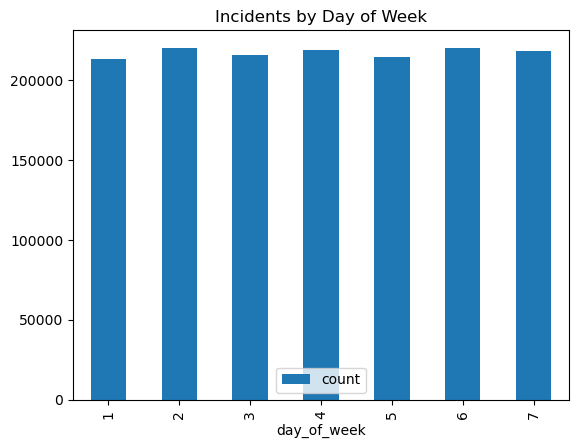

In [24]:
day_of_week_data = df_cleaned_eda.groupBy("day_of_week").count().toPandas()
month_data = df_cleaned_eda.groupBy("month").count().toPandas()

day_of_week_data.plot(x="day_of_week", y="count", kind="bar", title="Incidents by Day of Week")
plt.show()



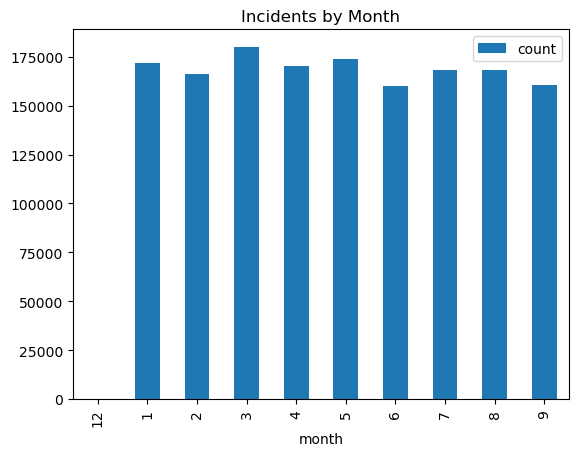

In [25]:
month_data.plot(x="month", y="count", kind="bar", title="Incidents by Month")
plt.show()


In [26]:
df_cleaned_eda = df_cleaned_eda.withColumn("latitude_rounded", F.round("Latitude", 3)) \
                       .withColumn("longitude_rounded", F.round("Longitude", 3))

top_locations = df_cleaned_eda.groupBy("latitude_rounded", "longitude_rounded").count().orderBy("count", ascending=False).limit(40000).toPandas()


In [27]:
heatmap_data = [[row["latitude_rounded"], row["longitude_rounded"], row["count"]] for index, row in top_locations.iterrows()]

m = folium.Map(
    location=[top_locations["latitude_rounded"].mean(), top_locations["longitude_rounded"].mean()],
    zoom_start=12
)

HeatMap(heatmap_data, radius=10, blur=15, max_zoom=1).add_to(m)

m.save("top_locations_heatmap.html")
m


# EDA FOR INCIDENT CLASSIFICATION

+---------------------------------------------------------+-----+
|TYP_DESC                                                 |count|
+---------------------------------------------------------+-----+
|VISIBILITY PATROL: DIRECTED                              |85811|
|SEE COMPLAINANT: OTHER/INSIDE                            |81903|
|AMBULANCE CASE: EDP/INSIDE                               |69473|
|DISPUTE: FAMILY                                          |62591|
|INVESTIGATE/POSSIBLE CRIME: CALLS FOR HELP/INSIDE        |59328|
|INVESTIGATE/POSSIBLE CRIME: SERIOUS/OTHER                |53826|
|ALARMS: COMMERCIAL/BURGLARY                              |53799|
|OTHER CRIMES (IN PROGRESS): HARASSMENT/INSIDE            |50462|
|DISPUTE: INSIDE                                          |48050|
|TRANSIT PATROL/INSPECTION BY NON-TRANSIT BUREAU PERSONNEL|39887|
+---------------------------------------------------------+-----+
only showing top 10 rows



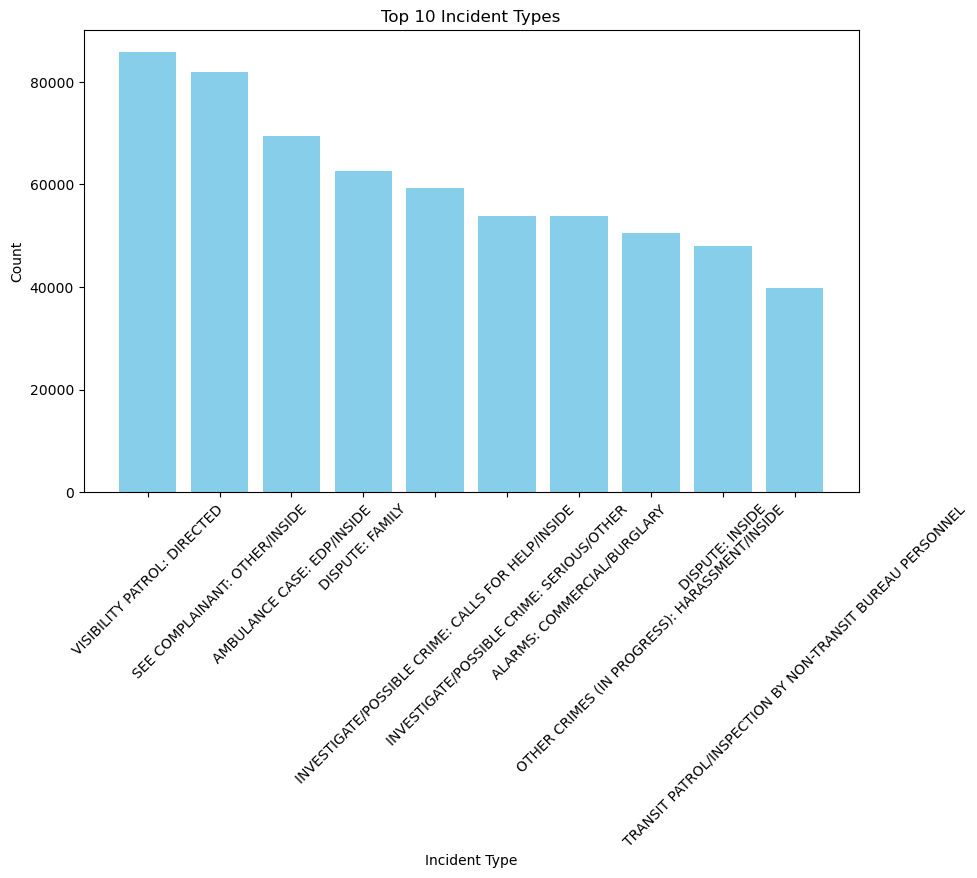

In [70]:
incident_type_analysis = df_cleaned_eda.groupBy("TYP_DESC").count().orderBy("count", ascending=False)

incident_type_analysis.show(10, truncate=False)

incident_type_pd = incident_type_analysis.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(incident_type_pd["TYP_DESC"], incident_type_pd["count"], color="skyblue")
plt.title("Top 10 Incident Types")
plt.xlabel("Incident Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()



In [ ]:
import pandas as pd

# Initialize table
results = []

# Define function to add results manually
def add_results(worker_nodes, rf_rmse, rf_r2, rf_acc, rf_prec, rf_rec, rf_time, gb_rmse, gb_r2, gb_time):
    results.append({
        'Worker Nodes': worker_nodes,
        'RF RMSE': rf_rmse,
        'RF R^2': rf_r2,
        'RF Accuracy': rf_acc,
        'RF Precision': rf_prec,
        'RF Recall': rf_rec,
        'RF Time Taken (s)': rf_time,
        'GB RMSE': gb_rmse,
        'GB R^2': gb_r2,
        'GB Time Taken (s)': gb_time,
    })

# Example of adding values manually
add_results(2, 3.6491, 0.9761, 0.99, 0.99, 0.99, 315.848, 1.616, 0.9953, 469.107)
add_results(3, 3.6491, 0.9761, 0.99, 0.99, 0.99, 325, 1.616, 0.99, 481)
add_results(4, 3.6491, 0.9761, 0.99, 0.99, 0.99, 327.45, 1.616, 0.9953, 473.94)

# Create DataFrame and display results
comparison_df = pd.DataFrame(results)
print(comparison_df)


+----------+-----+
|RADIO_CODE|count|
+----------+-----+
|75D       |85811|
|68Q1      |81903|
|54E1      |69473|
|52D6      |62591|
|10H1      |59328|
|10Y3      |53826|
|11C4      |53799|
|39H1      |50462|
|52D1      |48050|
|75T       |39887|
+----------+-----+
only showing top 10 rows



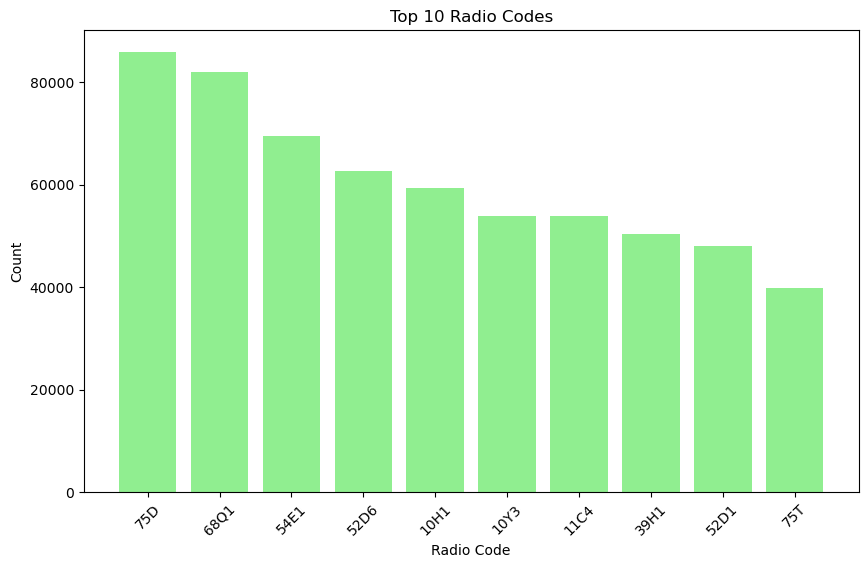

In [71]:
radio_code_analysis = df_cleaned_eda.groupBy("RADIO_CODE").count().orderBy("count", ascending=False)

radio_code_analysis.show(10, truncate=False)

radio_code_pd = radio_code_analysis.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(radio_code_pd["RADIO_CODE"], radio_code_pd["count"], color="lightgreen")
plt.title("Top 10 Radio Codes")
plt.xlabel("Radio Code")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


+------------+-------+
|CIP_JOBS    |count  |
+------------+-------+
|Non CIP     |1217682|
|Non Critical|140618 |
|Serious     |106119 |
|Critical    |54800  |
+------------+-------+



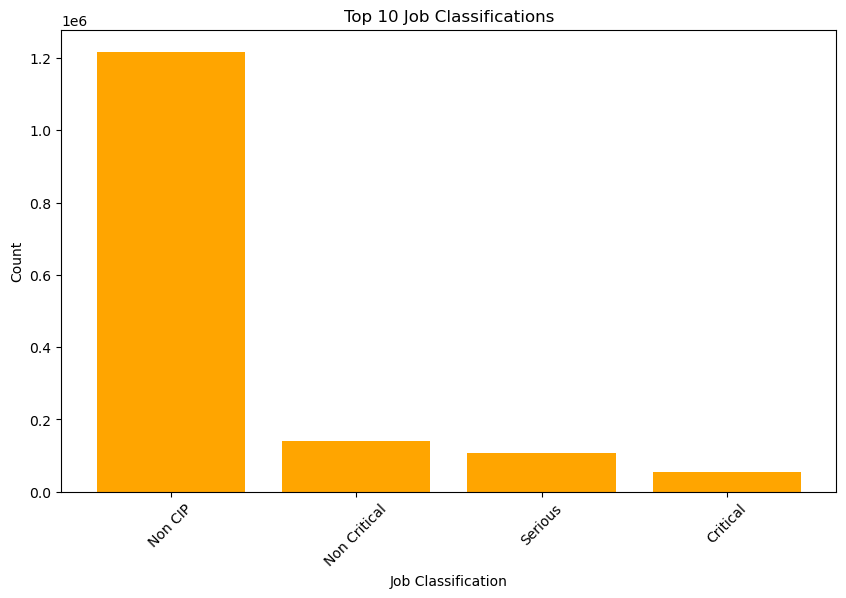

In [30]:

job_classification_analysis = df_cleaned_eda.groupBy("CIP_JOBS").count().orderBy("count", ascending=False)

job_classification_analysis.show(10, truncate=False)

job_classification_pd = job_classification_analysis.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(job_classification_pd["CIP_JOBS"], job_classification_pd["count"], color="orange")
plt.title("Top 10 Job Classifications")
plt.xlabel("Job Classification")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


+---------+---------------------------------------------------------+-----+
|BORO_NM  |TYP_DESC                                                 |count|
+---------+---------------------------------------------------------+-----+
|BROOKLYN |VISIBILITY PATROL: DIRECTED                              |32476|
|BROOKLYN |SEE COMPLAINANT: OTHER/INSIDE                            |31219|
|MANHATTAN|VISIBILITY PATROL: DIRECTED                              |21704|
|BROOKLYN |AMBULANCE CASE: EDP/INSIDE                               |21156|
|BROOKLYN |DISPUTE: FAMILY                                          |20031|
|BROOKLYN |INVESTIGATE/POSSIBLE CRIME: CALLS FOR HELP/INSIDE        |19206|
|QUEENS   |SEE COMPLAINANT: OTHER/INSIDE                            |18806|
|MANHATTAN|ALARMS: COMMERCIAL/BURGLARY                              |18684|
|BROOKLYN |INVESTIGATE/POSSIBLE CRIME: SERIOUS/OTHER                |17696|
|BROOKLYN |TRANSIT PATROL/INSPECTION BY NON-TRANSIT BUREAU PERSONNEL|17104|
+---------+-

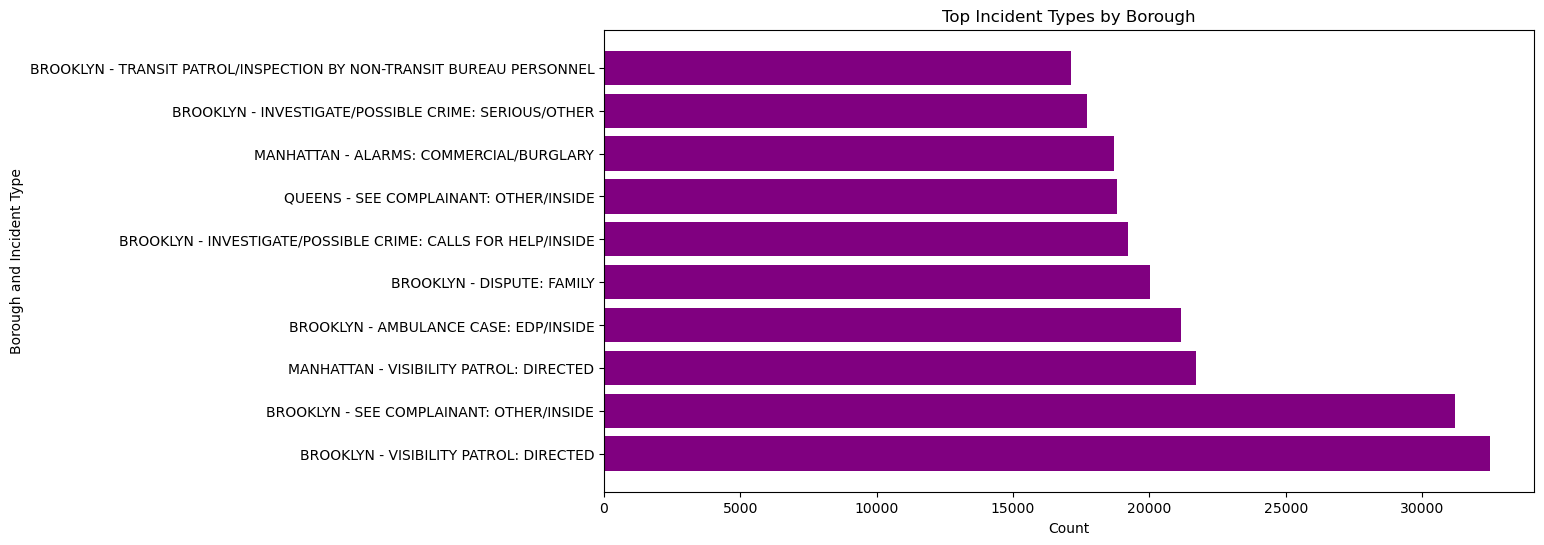

In [31]:
# Group by borough and incident type
incident_types_by_borough = df_cleaned_eda.groupBy("BORO_NM", "TYP_DESC").count().orderBy("count", ascending=False)

incident_types_by_borough.show(10, truncate=False)

incident_types_pd = incident_types_by_borough.limit(10).toPandas()

plt.figure(figsize=(12, 6))
plt.barh(incident_types_pd["BORO_NM"] + " - " + incident_types_pd["TYP_DESC"], incident_types_pd["count"], color="purple")
plt.title("Top Incident Types by Borough")
plt.xlabel("Count")
plt.ylabel("Borough and Incident Type")
plt.show()


In [32]:
response_time_by_borough = df_cleaned_eda.groupBy("BORO_NM").mean("dispatch_time", "arrival_time", "total_response_time")
response_time_by_borough.show(truncate=False)


+-------------+------------------+------------------+------------------------+
|BORO_NM      |avg(dispatch_time)|avg(arrival_time) |avg(total_response_time)|
+-------------+------------------+------------------+------------------------+
|QUEENS       |3.4332315183604516|19.172429105356045|22.60586888162176       |
|BRONX        |3.742271012683865 |17.651551254424962|21.393927382916427      |
|MANHATTAN    |3.0732346362753376|15.06390266740991 |18.1371637638107        |
|BROOKLYN     |2.9635499758643937|16.63173771245205 |19.595526404670345      |
|STATEN ISLAND|2.848513425194413 |15.632137955451899|18.480836147269635      |
|(null)       |1.568095238095238 |13.253333333333334|14.820952380952384      |
+-------------+------------------+------------------+------------------------+



In [33]:
df_cleaned_eda = df_cleaned_eda.withColumn("hour", F.hour("INCIDENT_TIME")) \
                               .withColumn("day_of_week", F.dayofweek("INCIDENT_DATE"))

response_time_by_hour = df_cleaned_eda.groupBy("hour").mean("dispatch_time", "arrival_time", "total_response_time")
response_time_by_hour.show(truncate=False)

response_time_by_day = df_cleaned_eda.groupBy("day_of_week").mean("dispatch_time", "arrival_time", "total_response_time")
response_time_by_day.show(truncate=False)


+----+------------------+------------------+------------------------+
|hour|avg(dispatch_time)|avg(arrival_time) |avg(total_response_time)|
+----+------------------+------------------+------------------------+
|22  |3.1272606028272865|13.53621373542937 |16.66363704831049       |
|23  |4.341739894208651 |18.10833291043063 |22.450261354985987      |
|0   |2.7815602304781795|14.271719284559152|17.05347188043951       |
|1   |2.467993675038265 |12.777316433127371|15.245506922132085      |
|2   |2.3968036431300566|12.546193712664378|14.94316325531275       |
|3   |2.4486705376843902|12.623134130764058|15.07200092904415       |
|4   |2.4914846488502476|13.001222871349647|15.492924549409468      |
|5   |2.507468121395905 |13.641176868723159|16.148846684895787      |
|6   |2.6962617963524047|14.082330018061256|16.77873069976859       |
|7   |4.150677509717355 |23.767868667348697|27.918648237823497      |
|8   |2.567756004268294 |18.62475393932958 |21.192663220479318      |
|9   |2.860873968184

+-----------+------------------+------------------+------------------------+
|day_of_week|avg(dispatch_time)|avg(arrival_time) |avg(total_response_time)|
+-----------+------------------+------------------+------------------------+
|1          |3.2058363638085847|16.66860969375259 |19.87459903776274       |
|2          |3.2196181884301733|17.178221288001104|20.39801754306018       |
|3          |3.1854086990445323|16.848214973788462|20.03376726414887       |
|4          |3.1067741064125314|16.789266403250615|19.89619612941861       |
|5          |3.23745730002018  |16.945285148232344|20.18288635091962       |
|6          |3.3220365491380233|17.247511106462397|20.569702146793453      |
|7          |3.2316336881350463|16.921222294125407|20.15301777673505       |
+-----------+------------------+------------------+------------------------+



In [34]:
response_time_by_incident = df_cleaned_eda.groupBy("TYP_DESC").mean("dispatch_time", "arrival_time", "total_response_time")
response_time_by_incident.orderBy("avg(total_response_time)", ascending=False).show(10, truncate=False)


+---------------------------------------------------+------------------+------------------+------------------------+
|TYP_DESC                                           |avg(dispatch_time)|avg(arrival_time) |avg(total_response_time)|
+---------------------------------------------------+------------------+------------------+------------------------+
|CELLULAR OPEN LINE                                 |14.65             |60.17             |74.82                   |
|LARCENY (PAST): VEHICLE/SCHOOL                     |7.983333333333333 |50.50666666666666 |58.48666666666666       |
|DISORDERLY: NOISE/OUTSIDE                          |8.43              |46.18             |54.62                   |
|UTILITY TROUBLE (SPECIFY): LTD ACC HWY             |1.2               |52.85             |54.05                   |
|ASSAULT (PAST): OTHER/LTD ACC HWY                  |8.233333333333333 |41.54333333333333 |49.776666666666664      |
|LARCENY (PAST): OTHER/LTD ACC HWY                  |8.540000000

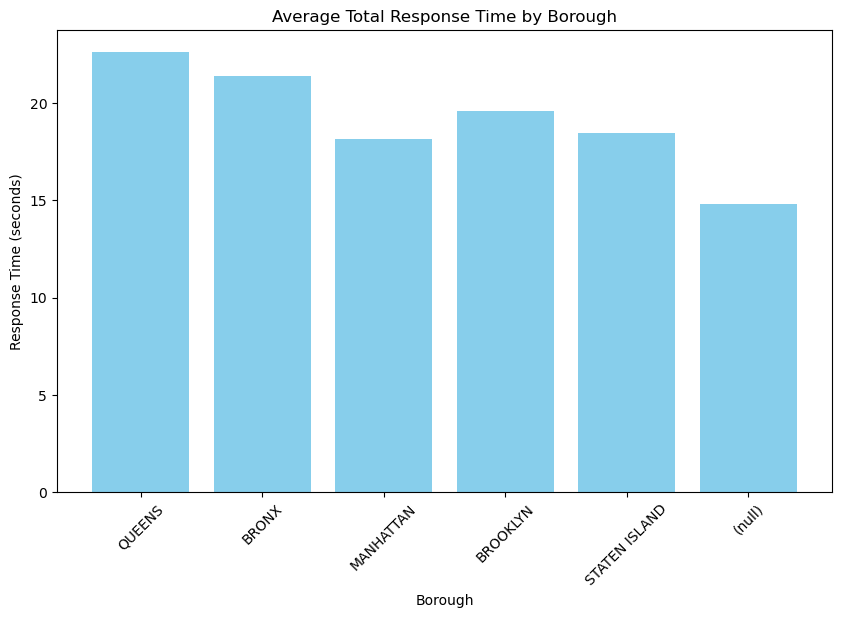

In [35]:
response_time_borough_pd = response_time_by_borough.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(response_time_borough_pd["BORO_NM"], response_time_borough_pd["avg(total_response_time)"], color="skyblue")
plt.title("Average Total Response Time by Borough")
plt.xlabel("Borough")
plt.ylabel("Response Time (seconds)")
plt.xticks(rotation=45)
plt.show()


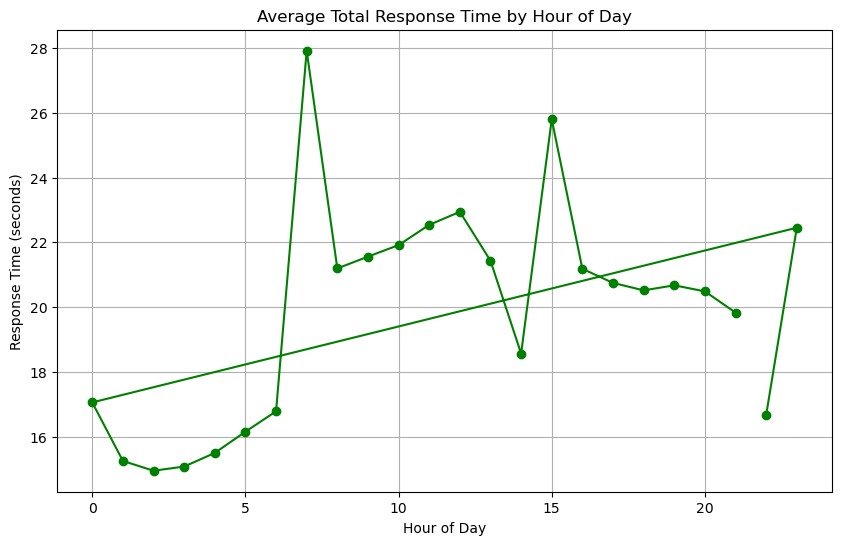

In [36]:
response_time_hour_pd = response_time_by_hour.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(response_time_hour_pd["hour"], response_time_hour_pd["avg(total_response_time)"], marker="o", color="green")
plt.title("Average Total Response Time by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Response Time (seconds)")
plt.grid()
plt.show()


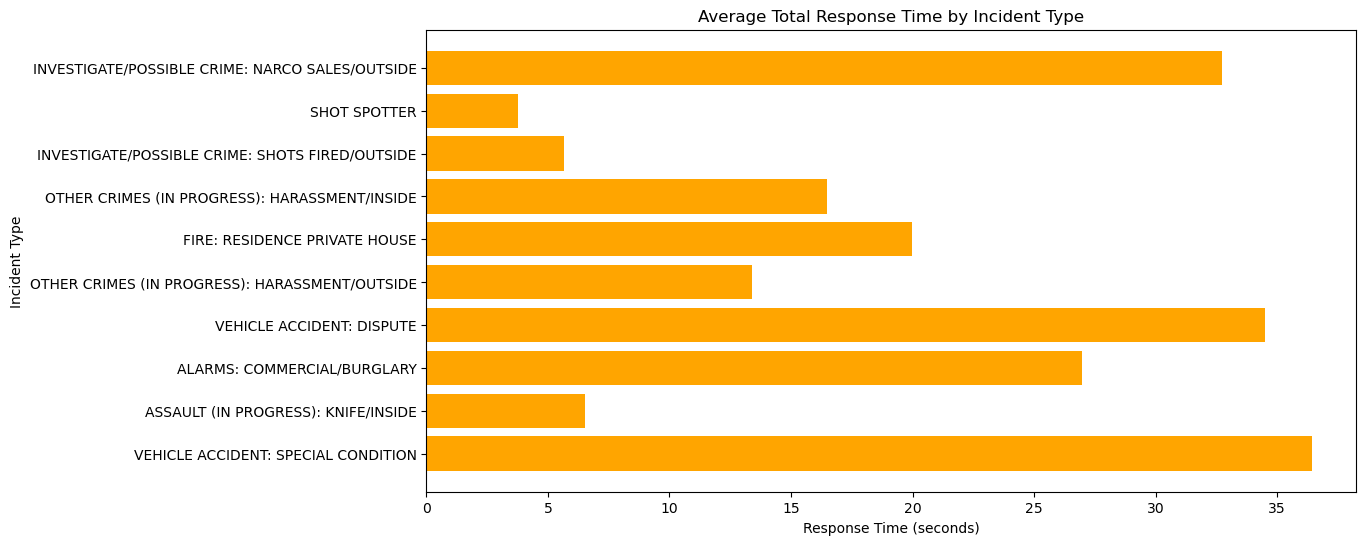

In [37]:
response_time_incident_pd = response_time_by_incident.limit(10).toPandas()

plt.figure(figsize=(12, 6))
plt.barh(response_time_incident_pd["TYP_DESC"], response_time_incident_pd["avg(total_response_time)"], color="orange")
plt.title("Average Total Response Time by Incident Type")
plt.xlabel("Response Time (seconds)")
plt.ylabel("Incident Type")
plt.show()


# Modeling

## Linear Regression

In [38]:
feature_columns = ["dispatch_time", "arrival_time"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_prepared = assembler.transform(df_cleaned).select("features", "total_response_time")

print("Prepared Data for Linear Regression:")
df_prepared.show(5, truncate=False)


Prepared Data for Linear Regression:
+------------+-------------------+
|features    |total_response_time|
+------------+-------------------+
|[0.97,77.65]|78.62              |
|[1.13,12.13]|13.27              |
|[4.5,5.83]  |10.33              |
|[7.18,17.13]|24.32              |
|[8.17,28.13]|36.3               |
+------------+-------------------+
only showing top 5 rows



In [39]:
# Spliting the data into train and test sets (80% train, 20% test)
train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=42)

print("Training Data Count:", train_data.count())
print("Test Data Count:", test_data.count())


Training Data Count: 912778


Test Data Count: 606441


In [40]:
lr = LinearRegression(featuresCol="features", labelCol="total_response_time", predictionCol="prediction")

lr_model = lr.fit(train_data)

print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


24/12/17 12:12:23 WARN Instrumentation: [4beb4b3b] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [0.9999813888156942,0.9999967289283758]
Intercept: 0.00026806356868136423


In [41]:
predictions = lr_model.transform(test_data)
print("Linear Regression Predictions:")
predictions.select("features", "total_response_time", "prediction").show(10, truncate=False)

evaluator = RegressionEvaluator(labelCol="total_response_time", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

evaluator_r2 = RegressionEvaluator(labelCol="total_response_time", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R2 Score:", r2)


Linear Regression Predictions:


+-----------+-------------------+-------------------+
|features   |total_response_time|prediction         |
+-----------+-------------------+-------------------+
|[0.02,0.02]|0.03               |0.04026762592356276|
|[0.02,0.02]|0.03               |0.04026762592356276|
|[0.02,0.02]|0.03               |0.04026762592356276|
|[0.02,0.02]|0.03               |0.04026762592356276|
|[0.02,0.02]|0.03               |0.04026762592356276|
|[0.02,0.02]|0.03               |0.04026762592356276|
|[0.02,0.02]|0.03               |0.04026762592356276|
|[0.02,0.02]|0.03               |0.04026762592356276|
|[0.02,0.02]|0.03               |0.04026762592356276|
|[0.02,0.02]|0.03               |0.04026762592356276|
+-----------+-------------------+-------------------+
only showing top 10 rows



Root Mean Squared Error (RMSE): 0.004880453984611745


R2 Score: 0.9999999572697764


In [42]:
# Model summary
training_summary = lr_model.summary

print("Training Summary:")
print("RMSE on Training Data:", training_summary.rootMeanSquaredError)
print("R2 on Training Data:", training_summary.r2)


Training Summary:
RMSE on Training Data: 0.00488897638958177
R2 on Training Data: 0.9999999571389353


## Random Forest

In [43]:
rf = RandomForestRegressor(featuresCol="features", labelCol="total_response_time", predictionCol="prediction", numTrees=100)
rf_model = rf.fit(train_data)

print("Random Forest model training completed!")


Random Forest model training completed!


In [44]:
predictions = rf_model.transform(test_data)

print("Predictions on Test Data:")
predictions.select("features", "total_response_time", "prediction").show(10, truncate=False)


Predictions on Test Data:


+-----------+-------------------+------------------+
|features   |total_response_time|prediction        |
+-----------+-------------------+------------------+
|[0.02,0.02]|0.03               |0.7888153334353398|
|[0.02,0.02]|0.03               |0.7888153334353398|
|[0.02,0.02]|0.03               |0.7888153334353398|
|[0.02,0.02]|0.03               |0.7888153334353398|
|[0.02,0.02]|0.03               |0.7888153334353398|
|[0.02,0.02]|0.03               |0.7888153334353398|
|[0.02,0.02]|0.03               |0.7888153334353398|
|[0.02,0.02]|0.03               |0.7888153334353398|
|[0.02,0.02]|0.03               |0.7888153334353398|
|[0.02,0.02]|0.03               |0.7888153334353398|
+-----------+-------------------+------------------+
only showing top 10 rows



In [45]:
evaluator_rmse = RegressionEvaluator(labelCol="total_response_time", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="total_response_time", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")


Root Mean Squared Error (RMSE): 3.678746451618793
R2 Score: 0.9757219146809109


In [49]:
threshold = 60  
df_classification = df_cleaned.withColumn("label", F.when(F.col("total_response_time") > threshold, 1).otherwise(0))

feature_columns = ["dispatch_time", "arrival_time"]  
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_prepared = assembler.transform(df_classification).select("features", "label")

train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=42)


In [50]:
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="label", predictionCol="prediction", numTrees=100)

rf_model = rf_classifier.fit(train_data)

predictions = rf_model.transform(test_data)

predictions.select("features", "label", "prediction").show(10)


+-----------+-----+----------+
|   features|label|prediction|
+-----------+-----+----------+
|[0.02,0.02]|    0|       0.0|
|[0.02,0.02]|    0|       0.0|
|[0.02,0.02]|    0|       0.0|
|[0.02,0.02]|    0|       0.0|
|[0.02,0.02]|    0|       0.0|
|[0.02,0.02]|    0|       0.0|
|[0.02,0.02]|    0|       0.0|
|[0.02,0.02]|    0|       0.0|
|[0.02,0.02]|    0|       0.0|
|[0.02,0.02]|    0|       0.0|
+-----------+-----+----------+
only showing top 10 rows



In [51]:

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.991593013606607
Precision: 0.9919249969662844
Recall: 0.991593013606607


## Gradient Boosting

In [46]:
gbt = GBTRegressor(featuresCol="features", labelCol="total_response_time", predictionCol="prediction", maxIter=100)

gbt_model = gbt.fit(train_data)

print("Gradient Boosting model training completed!")

Gradient Boosting model training completed!


In [47]:
predictions = gbt_model.transform(test_data)

print("Predictions on Test Data:")
predictions.select("features", "total_response_time", "prediction").show(10, truncate=False)


Predictions on Test Data:


+-----------+-------------------+--------------------+
|features   |total_response_time|prediction          |
+-----------+-------------------+--------------------+
|[0.02,0.02]|0.03               |0.032046177496824646|
|[0.02,0.02]|0.03               |0.032046177496824646|
|[0.02,0.02]|0.03               |0.032046177496824646|
|[0.02,0.02]|0.03               |0.032046177496824646|
|[0.02,0.02]|0.03               |0.032046177496824646|
|[0.02,0.02]|0.03               |0.032046177496824646|
|[0.02,0.02]|0.03               |0.032046177496824646|
|[0.02,0.02]|0.03               |0.032046177496824646|
|[0.02,0.02]|0.03               |0.032046177496824646|
|[0.02,0.02]|0.03               |0.032046177496824646|
+-----------+-------------------+--------------------+
only showing top 10 rows



In [48]:
evaluator_rmse = RegressionEvaluator(labelCol="total_response_time", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="total_response_time", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")


Root Mean Squared Error (RMSE): 1.5631399430441817
R2 Score: 0.9956166066697358


## K-Means clustering

In [80]:
selected_features = ["Latitude", "Longitude"]  

assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

df_prepared = assembler.transform(df_cleaned).select("features", *selected_features)

print("Prepared Data for K-means Clustering:")
df_prepared.show(5, truncate=False)


Prepared Data for K-means Clustering:
+----------------------+---------+----------+
|features              |Latitude |Longitude |
+----------------------+---------+----------+
|[40.743037,-73.916826]|40.743037|-73.916826|
|[40.776057,-73.934906]|40.776057|-73.934906|
|[40.86433,-73.867393] |40.86433 |-73.867393|
|[40.862274,-73.929562]|40.862274|-73.929562|
|[40.764566,-73.971757]|40.764566|-73.971757|
+----------------------+---------+----------+
only showing top 5 rows



In [53]:
k = 5  
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)

kmeans_model = kmeans.fit(df_prepared)

df_clusters = kmeans_model.transform(df_prepared)

print("Data with Cluster Assignments:")
df_clusters.select("Latitude", "Longitude", "cluster").show(10)


Data with Cluster Assignments:
+---------+----------+-------+
| Latitude| Longitude|cluster|
+---------+----------+-------+
|40.743037|-73.916826|      4|
|40.776057|-73.934906|      4|
| 40.86433|-73.867393|      0|
|40.862274|-73.929562|      0|
|40.764566|-73.971757|      4|
|40.706102|-73.793242|      2|
|40.740547|-74.008547|      4|
|40.706528|-73.791997|      2|
|40.770813|-73.811147|      2|
| 40.70215|-73.790564|      2|
+---------+----------+-------+
only showing top 10 rows



In [54]:
centers = kmeans_model.clusterCenters()
print("Cluster Centers (High-Risk Zones):")
for idx, center in enumerate(centers):
    print(f"Cluster {idx}: {center}")


Cluster Centers (High-Risk Zones):
Cluster 0: [ 40.83743223 -73.90282894]
Cluster 1: [ 40.60199467 -74.12495999]
Cluster 2: [ 40.70022946 -73.81260808]
Cluster 3: [ 40.65558713 -73.95103755]
Cluster 4: [ 40.74828972 -73.96746351]


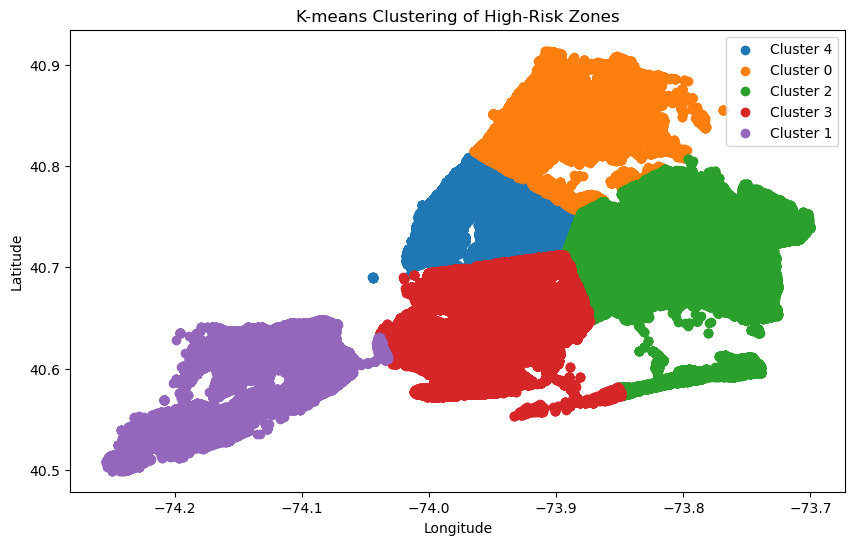

In [55]:
df_pandas = df_clusters.select("Latitude", "Longitude", "cluster").toPandas()

plt.figure(figsize=(10, 6))
for cluster_id in df_pandas["cluster"].unique():
    cluster_data = df_pandas[df_pandas["cluster"] == cluster_id]
    plt.scatter(cluster_data["Longitude"], cluster_data["Latitude"], label=f"Cluster {cluster_id}")

plt.title("K-means Clustering of High-Risk Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


In [57]:
centers = kmeans_model.clusterCenters()
cluster_centers = {i: centers[i] for i in range(len(centers))}

sc = SparkContext.getOrCreate()
broadcast_centers = sc.broadcast(cluster_centers)

def euclidean_distance(point, cluster_id):
    center = broadcast_centers.value[cluster_id]  
    return float(math.sqrt(sum((point[i] - center[i]) ** 2 for i in range(len(center)))))

distance_udf = F.udf(euclidean_distance, DoubleType())

df_with_distance = df_clusters.withColumn(
    "intra_cluster_distance",
    distance_udf(F.col("features"), F.col("cluster"))
)

print("Data with Intra-Cluster Distances:")
df_with_distance.select("features", "cluster", "intra_cluster_distance").show(10, truncate=False)


Data with Intra-Cluster Distances:


+----------------------+-------+----------------------+
|features              |cluster|intra_cluster_distance|
+----------------------+-------+----------------------+
|[40.743037,-73.916826]|4      |0.050909216914502266  |
|[40.776057,-73.934906]|4      |0.04279034383589714   |
|[40.86433,-73.867393] |0      |0.04448815501335516   |
|[40.862274,-73.929562]|0      |0.036493420205705035  |
|[40.764566,-73.971757]|4      |0.016833048236449075  |
|[40.706102,-73.793242]|2      |0.02023688849743139   |
|[40.740547,-74.008547]|4      |0.041806732023081376  |
|[40.706528,-73.791997]|2      |0.0215519858106137    |
|[40.770813,-73.811147]|2      |0.07059866101884622   |
|[40.70215,-73.790564] |2      |0.022127579853446676  |
+----------------------+-------+----------------------+
only showing top 10 rows



In [58]:
def pairwise_distances(centers):
    k = len(centers)
    distances = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            if i != j:
                distances[i][j] = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
    return distances

inter_cluster_distances = pairwise_distances(centers)

print("Inter-Cluster Distances:")
print(inter_cluster_distances)


Inter-Cluster Distances:
[[0.         0.32368665 0.16420842 0.18812685 0.11010911]
 [0.32368665 0.         0.32743517 0.18199222 0.21495902]
 [0.16420842 0.32743517 0.         0.14544984 0.16214189]
 [0.18812685 0.18199222 0.14544984 0.         0.09414659]
 [0.11010911 0.21495902 0.16214189 0.09414659 0.        ]]


In [59]:
dispersion_values = df_with_distance.groupBy("cluster").agg(mean("intra_cluster_distance").alias("dispersion")).collect()

dispersion_dict = {row['cluster']: row['dispersion'] for row in dispersion_values}

db_index = 0
k = len(centers)

for i in range(k):
    max_ratio = 0
    for j in range(k):
        if i != j:
            ratio = (dispersion_dict[i] + dispersion_dict[j]) / inter_cluster_distances[i][j]
            max_ratio = max(max_ratio, ratio)
    db_index += max_ratio

db_index /= k

print(f"Davies-Bouldin Index (DBI): {db_index}")


Davies-Bouldin Index (DBI): 0.7477194917382969


In [60]:
feature_columns = ["Latitude", "Longitude"]  
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_prepared = assembler.transform(df_cleaned)


k = 5  
kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=k, seed=42)
kmeans_model = kmeans.fit(df_prepared)

df_clusters = kmeans_model.transform(df_prepared)

evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette_score = evaluator.evaluate(df_clusters)

print(f"Silhouette Score: {silhouette_score}")


Silhouette Score: 0.5913598921815876


# Scale in 

In [61]:
# Creating data subsets at 20%, 50%, 75%, and 100% of the full dataset
fractions = {"20%": 0.2, "50%": 0.5, "75%": 0.75, "100%": 1.0}
data_subsets = {}

for key, fraction in fractions.items():
    data_subsets[key] = df_cleaned.sample(fraction=fraction, seed=42)

print("Data subsets created for 20%, 50%, 75%, and 100%")


Data subsets created for 20%, 50%, 75%, and 100%


In [62]:
rf = RandomForestRegressor(featuresCol="features", labelCol="total_response_time", predictionCol="prediction", numTrees=100)
gbt = GBTRegressor(featuresCol="features", labelCol="total_response_time", predictionCol="prediction", maxIter=100)

evaluator_rmse = RegressionEvaluator(labelCol="total_response_time", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="total_response_time", predictionCol="prediction", metricName="r2")

results = []

for size, df_subset in data_subsets.items():

    assembler = VectorAssembler(inputCols=["dispatch_time", "arrival_time"], outputCol="features")
    df_prepared = assembler.transform(df_subset).select("features", "total_response_time")
    
    train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=42)
    
    # Random Forest
    start_time = time.time()
    rf_model = rf.fit(train_data)
    rf_predictions = rf_model.transform(test_data)
    rf_time = time.time() - start_time
    rf_rmse = evaluator_rmse.evaluate(rf_predictions)
    rf_r2 = evaluator_r2.evaluate(rf_predictions)
    
    # Gradient Boosting
    start_time = time.time()
    gbt_model = gbt.fit(train_data)
    gbt_predictions = gbt_model.transform(test_data)
    gbt_time = time.time() - start_time
    gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
    gbt_r2 = evaluator_r2.evaluate(gbt_predictions)
    
    # Store results
    results.append((size, rf_time, rf_rmse, rf_r2, gbt_time, gbt_rmse, gbt_r2))
    print(f"Data Size: {size} - RF: Time={rf_time:.2f}s, RMSE={rf_rmse:.4f}, R²={rf_r2:.4f} | GBT: Time={gbt_time:.2f}s, RMSE={gbt_rmse:.4f}, R²={gbt_r2:.4f}")


Data Size: 20% - RF: Time=237.97s, RMSE=3.6436, R²=0.9763 | GBT: Time=299.88s, RMSE=1.6169, R²=0.9953


Data Size: 50% - RF: Time=271.65s, RMSE=3.5704, R²=0.9771 | GBT: Time=365.60s, RMSE=1.6424, R²=0.9952


Data Size: 75% - RF: Time=300.54s, RMSE=3.5671, R²=0.9771 | GBT: Time=420.71s, RMSE=1.6325, R²=0.9952


Data Size: 100% - RF: Time=325.80s, RMSE=3.6491, R²=0.9761 | GBT: Time=481.00s, RMSE=1.6164, R²=0.9953


In [63]:
results_df = pd.DataFrame(results, columns=["Data Size", 
                                            "RF Training Time", "RF RMSE", "RF R²",
                                            "GBT Training Time", "GBT RMSE", "GBT R²"])

print("Scale-In Experiment Results:")
print(results_df)


Scale-In Experiment Results:
  Data Size  RF Training Time   RF RMSE     RF R²  GBT Training Time  \
0       20%        237.972965  3.643566  0.976288         299.883065   
1       50%        271.645378  3.570368  0.977129         365.595535   
2       75%        300.540333  3.567099  0.977091         420.709476   
3      100%        325.801209  3.649114  0.976130         481.002217   

   GBT RMSE    GBT R²  
0  1.616928  0.995330  
1  1.642350  0.995161  
2  1.632526  0.995202  
3  1.616351  0.995317  


In [64]:
print(tabulate(results_df, headers="keys", tablefmt="grid"))


+----+-------------+--------------------+-----------+----------+---------------------+------------+----------+
|    | Data Size   |   RF Training Time |   RF RMSE |    RF R² |   GBT Training Time |   GBT RMSE |   GBT R² |
+====+=============+====================+===========+==========+=====================+============+==========+
|  0 | 20%         |            237.973 |   3.64357 | 0.976288 |             299.883 |    1.61693 | 0.99533  |
+----+-------------+--------------------+-----------+----------+---------------------+------------+----------+
|  1 | 50%         |            271.645 |   3.57037 | 0.977129 |             365.596 |    1.64235 | 0.995161 |
+----+-------------+--------------------+-----------+----------+---------------------+------------+----------+
|  2 | 75%         |            300.54  |   3.5671  | 0.977091 |             420.709 |    1.63253 | 0.995202 |
+----+-------------+--------------------+-----------+----------+---------------------+------------+----------+
|

In [65]:


html_table = results_df.to_html(index=False, border=1, justify="center")
display(HTML(html_table))


Data Size,RF Training Time,RF RMSE,RF R²,GBT Training Time,GBT RMSE,GBT R²
20%,237.972965,3.643566,0.976288,299.883065,1.616928,0.995330
50%,271.645378,3.570368,0.977129,365.595535,1.642350,0.995161
75%,300.540333,3.567099,0.977091,420.709476,1.632526,0.995202
100%,325.801209,3.649114,0.976130,481.002217,1.616351,0.995317


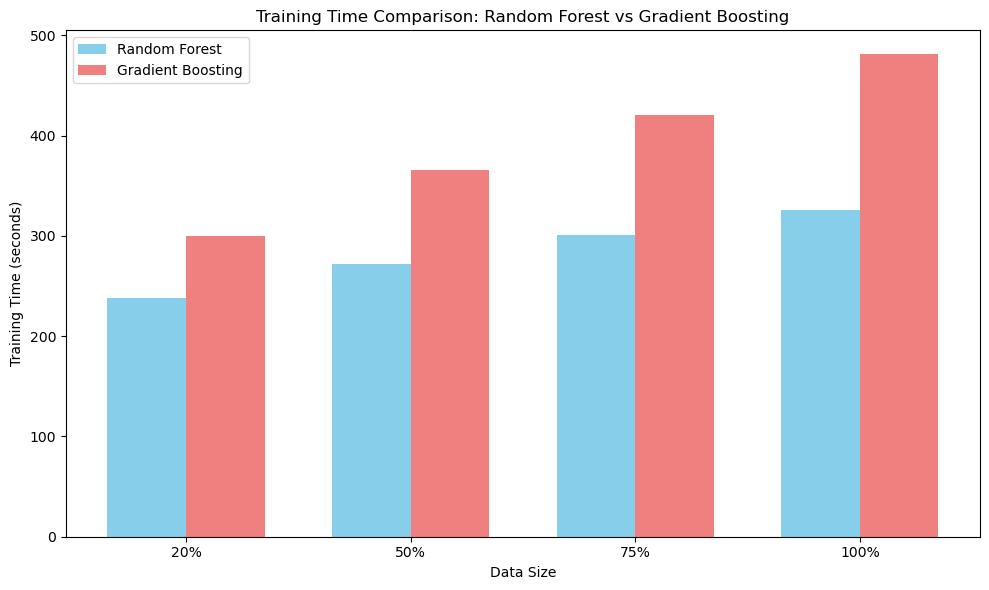

In [66]:
data_sizes = results_df["Data Size"]
rf_times = results_df["RF Training Time"]
gbt_times = results_df["GBT Training Time"]


bar_width = 0.35
index = np.arange(len(data_sizes))

plt.figure(figsize=(10, 6))
plt.bar(index, rf_times, bar_width, label="Random Forest", color="skyblue")
plt.bar(index + bar_width, gbt_times, bar_width, label="Gradient Boosting", color="lightcoral")

plt.xlabel("Data Size")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison: Random Forest vs Gradient Boosting")
plt.xticks(index + bar_width / 2, data_sizes)
plt.legend()

plt.tight_layout()
plt.show()


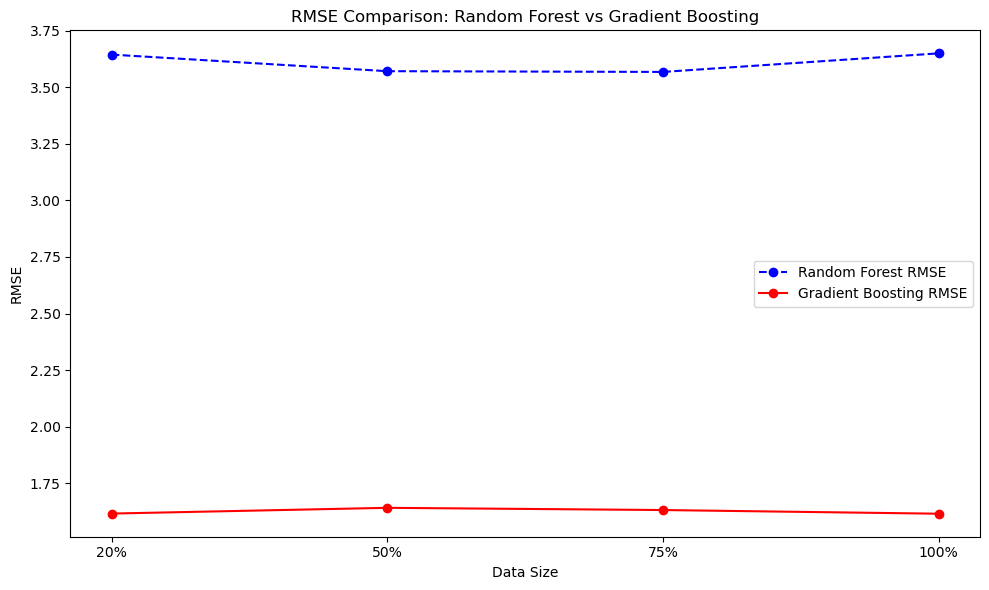

In [67]:
rf_rmse = results_df["RF RMSE"]
gbt_rmse = results_df["GBT RMSE"]

plt.figure(figsize=(10, 6))
plt.plot(data_sizes, rf_rmse, marker="o", label="Random Forest RMSE", color="blue", linestyle="--")
plt.plot(data_sizes, gbt_rmse, marker="o", label="Gradient Boosting RMSE", color="red", linestyle="-")

plt.xlabel("Data Size")
plt.ylabel("RMSE")
plt.title("RMSE Comparison: Random Forest vs Gradient Boosting")
plt.legend()

plt.tight_layout()
plt.show()


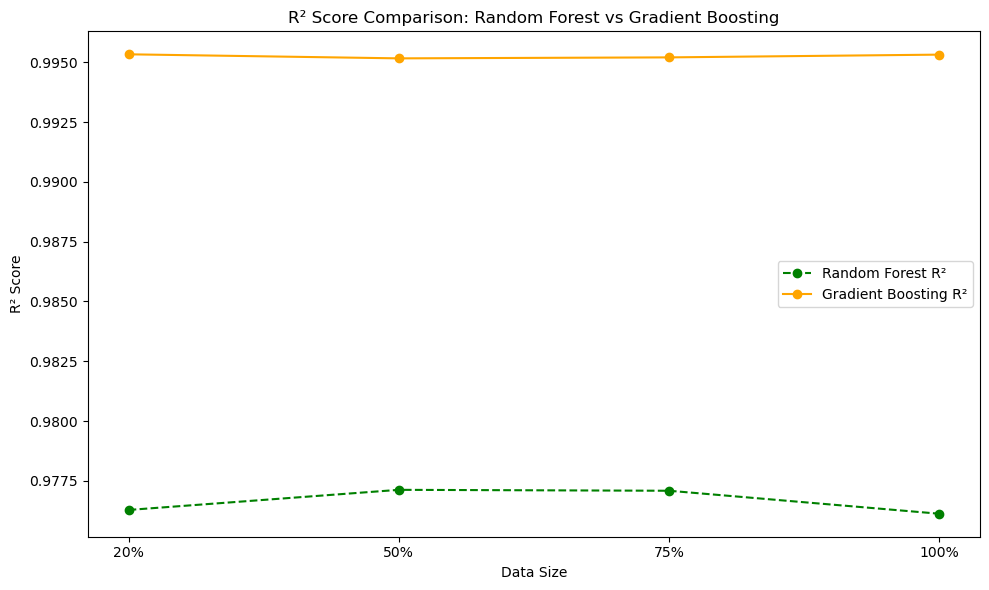

In [68]:
rf_r2 = results_df["RF R²"]
gbt_r2 = results_df["GBT R²"]

plt.figure(figsize=(10, 6))
plt.plot(data_sizes, rf_r2, marker="o", label="Random Forest R²", color="green", linestyle="--")
plt.plot(data_sizes, gbt_r2, marker="o", label="Gradient Boosting R²", color="orange", linestyle="-")

plt.xlabel("Data Size")
plt.ylabel("R² Score")
plt.title("R² Score Comparison: Random Forest vs Gradient Boosting")
plt.legend()

plt.tight_layout()
plt.show()


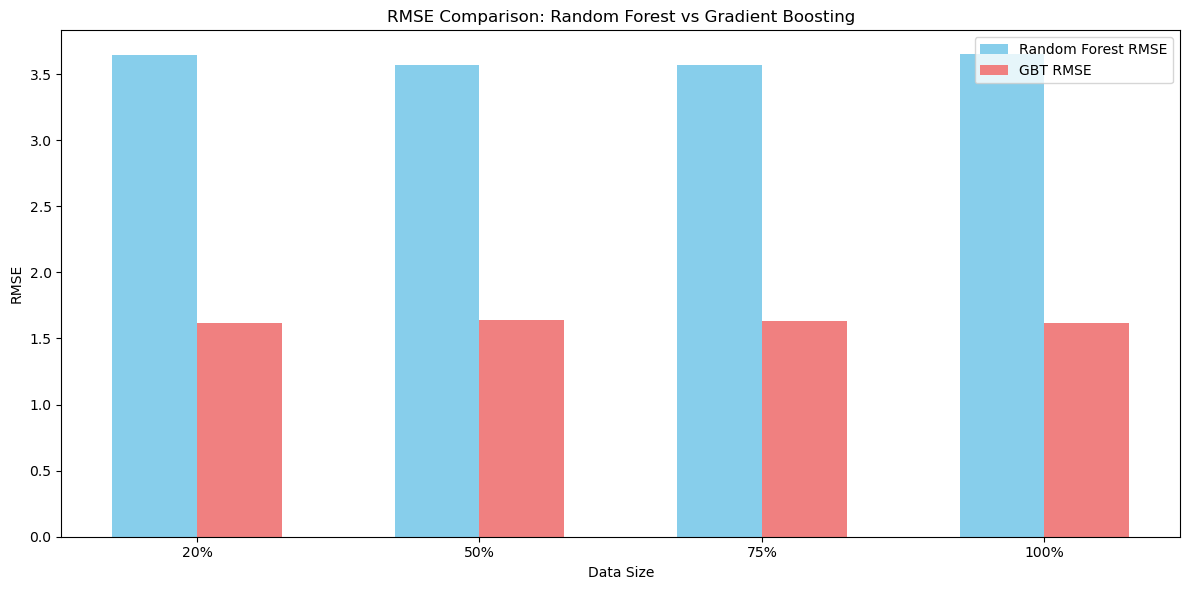

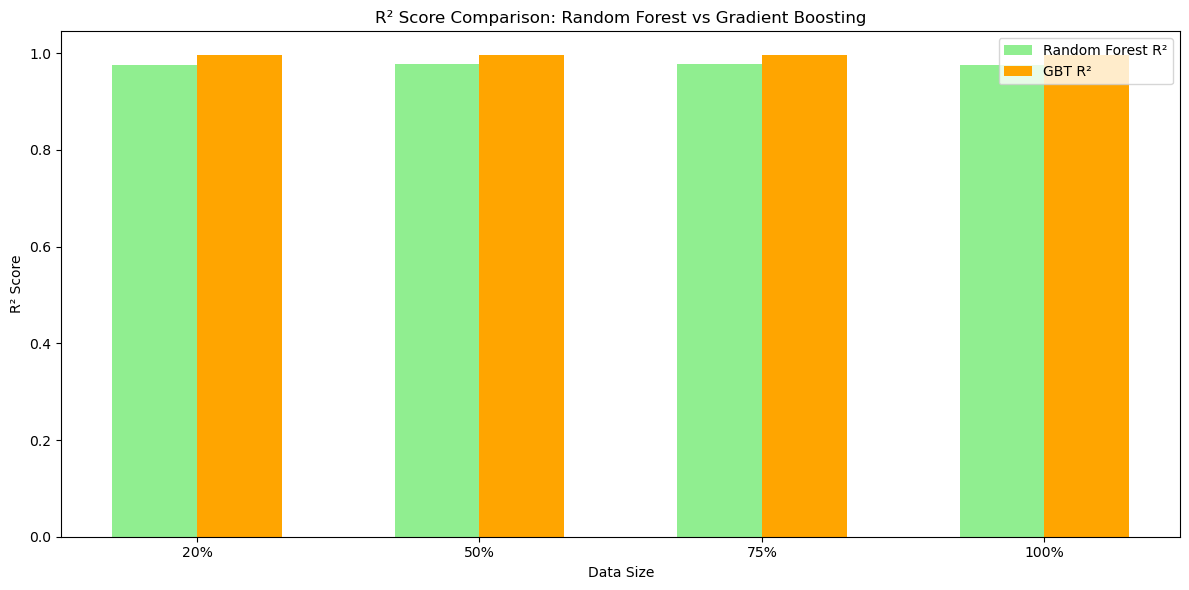

In [69]:
data_sizes = results_df["Data Size"]
rf_rmse = results_df["RF RMSE"]
gbt_rmse = results_df["GBT RMSE"]
rf_r2 = results_df["RF R²"]
gbt_r2 = results_df["GBT R²"]

bar_width = 0.3
index = np.arange(len(data_sizes))

plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, rf_rmse, bar_width, label="Random Forest RMSE", color="skyblue")
plt.bar(index + bar_width/2, gbt_rmse, bar_width, label="GBT RMSE", color="lightcoral")

plt.xlabel("Data Size")
plt.ylabel("RMSE")
plt.title("RMSE Comparison: Random Forest vs Gradient Boosting")
plt.xticks(index, data_sizes)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, rf_r2, bar_width, label="Random Forest R²", color="lightgreen")
plt.bar(index + bar_width/2, gbt_r2, bar_width, label="GBT R²", color="orange")

plt.xlabel("Data Size")
plt.ylabel("R² Score")
plt.title("R² Score Comparison: Random Forest vs Gradient Boosting")
plt.xticks(index, data_sizes)
plt.legend()
plt.tight_layout()
plt.show()


In [96]:
df_clusters.show(5)  
predictions.show(5)  


+---------+----------+-------------------+------------------+--------------------+-------+
| Latitude| Longitude|total_response_time|        prediction|            features|cluster|
+---------+----------+-------------------+------------------+--------------------+-------+
|40.743037|-73.916826|              78.62|21.236297410076237|[40.743037,-73.91...|      4|
|40.776057|-73.934906|              13.27|21.236297410076237|[40.776057,-73.93...|      4|
| 40.86433|-73.867393|              10.33|21.236297410076237|[40.86433,-73.867...|      0|
|40.862274|-73.929562|              24.32|21.236297410076237|[40.862274,-73.92...|      0|
|40.764566|-73.971757|               36.3|21.236297410076237|[40.764566,-73.97...|      4|
+---------+----------+-------------------+------------------+--------------------+-------+
only showing top 5 rows

+---------+----------+-------------------+------------------+
| Latitude| Longitude|total_response_time|        prediction|
+---------+----------+----------

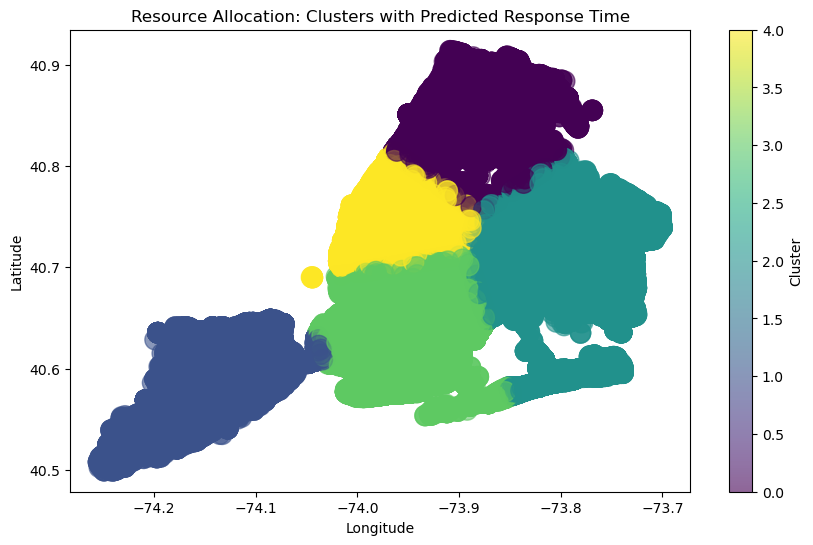

In [97]:

combined_pandas = combined_results.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(
    combined_pandas["Longitude"],
    combined_pandas["Latitude"],
    c=combined_pandas["cluster"],
    s=combined_pandas["prediction"] * 10,  
    cmap="viridis",
    alpha=0.6
)
plt.colorbar(label="Cluster")
plt.title("Resource Allocation: Clusters with Predicted Response Time")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
